In [19]:
%reload_ext autoreload
%autoreload 2
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
from spikeinterface.exporters import export_to_phy
print(f"SpikeInterface version: {si.__version__}")
import probeinterface as pi
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os, sys
import pickle
import re
from datetime import datetime
import shutil
from joblib import Parallel, delayed

from scipy.io import loadmat
from utils.data_io import extract_datetime, create_channel_map, get_sampling_rate
# Note: If importing fails, please restart the kernel to refresh the module.

n_cpus = os.cpu_count()
n_jobs = n_cpus - 6
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="2s", progress_bar=True)


SpikeInterface version: 0.103.2


In [20]:
# Detect curated sorting folders under stempath/Name/RatID/sessionID
stempath = "/local/workdir/ys2375/data/ayadataB1/Sorting_comparison"

# Expected structure: stempath/Name/RatID/sessionID/*_curated or *_spi_curated
session_dirs = glob.glob(os.path.join(stempath, "*", "*", "*"))

# Empty set means all people
target_names = set()
print("Target names: ALL" if len(target_names) == 0 else f"Target names: {sorted(target_names)}")

curated_pairs = {}
for session_dir in session_dirs:
    if not os.path.isdir(session_dir):
        continue

    name = os.path.basename(os.path.dirname(os.path.dirname(session_dir)))
    if len(target_names) > 0 and name not in target_names:
        continue

    rat_id = os.path.basename(os.path.dirname(session_dir))
    session_id = os.path.basename(session_dir)
    pair_key = f"{name}/{rat_id}/{session_id}"

    curated_folder = None
    spi_curated_folder = None

    for folder in glob.glob(os.path.join(session_dir, "*")):
        if not os.path.isdir(folder):
            continue

        base = os.path.basename(folder)
        if base.endswith("_spi_curated"):
            spi_curated_folder = folder
        elif base.endswith("_curated") and not base.endswith("_spi_curated"):
            curated_folder = folder

    if curated_folder and spi_curated_folder:
        curated_pairs[pair_key] = {
            "curated": curated_folder,
            "spi_curated": spi_curated_folder,
        }

print(f"Found {len(curated_pairs)} sessions with both curated and spi_curated outputs.")
for k, v in curated_pairs.items():
    print(f"  {k}")
    print(f"    curated: {os.path.basename(v['curated'])}")
    print(f"    spi_curated: {os.path.basename(v['spi_curated'])}")

# Load sorting objects for each curated pair
sorting_pairs = {}
for pair_key, paths in curated_pairs.items():
    sorting_pairs[pair_key] = {}
    for label, folder in paths.items():
        phy_folder = folder

        if not os.path.exists(os.path.join(phy_folder, "spike_times.npy")):
            sorter_output_path = os.path.join(folder, "sorter_output")
            if os.path.exists(os.path.join(sorter_output_path, "spike_times.npy")):
                phy_folder = sorter_output_path

        if os.path.exists(os.path.join(phy_folder, "spike_times.npy")):
            try:
                sorting_pairs[pair_key][label] = se.read_phy(
                    folder_path=Path(phy_folder),
                    exclude_cluster_groups=["noise", "mua", "unsorted"],
                )
                print(f"Loaded {pair_key} - {label} ({os.path.relpath(phy_folder, stempath)})")
            except Exception as e:
                print(f"Failed to load {pair_key} - {label}: {e}")
        else:
            print(f"Skipping {pair_key} - {label}: no phy output found")

# Keep only complete pairs
sorting_pairs = {
    k: v for k, v in sorting_pairs.items() if "curated" in v and "spi_curated" in v
}
print(f"\nLoaded complete curated pairs: {len(sorting_pairs)}")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Target names: ALL
Found 9 sessions with both curated and spi_curated outputs.
  Yoshi/Sake/sake_day01
    curated: Kilosort_2026-01-01_221509_curated
    spi_curated: Kilosort_2026-01-01_221509_spi_curated
  Weiwei/HP04/day_32_20240430
    curated: Kilosort_2024-05-01_071006_curated
    spi_curated: Kilosort_2024-05-01_071006_spi_curated
  Antonio/HP15/hp15_day3_20241129
    curated: Kilosort_2024-12-30_065902_curated
    spi_curated: Kilosort_2024-12-30_065902_spi_curated
  Ryan/HP04/day_32_20240430
    curated: Kilosort_2024-05-01_071006_curated
    spi_curated: Kilosort_2024-05-01_071006_spi_curated
  Lindsey/NN2/day13
    curated: Kilosort_2022-08-12_141855_curated
    spi_curated: Kilosort_2022-08-12_141855_spi_curated
  Xiyu/OJR49/session_n
    curated: Kilosort_2022-04-04_230322_curated
    spi_curated: Kilosort_2022-04-04_230322_spi_curated
  P

/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


Loaded Weiwei/HP04/day_32_20240430 - curated (Weiwei/HP04/day_32_20240430/Kilosort_2024-05-01_071006_curated)
Loaded Weiwei/HP04/day_32_20240430 - spi_curated (Weiwei/HP04/day_32_20240430/Kilosort_2024-05-01_071006_spi_curated)


/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


Loaded Antonio/HP15/hp15_day3_20241129 - curated (Antonio/HP15/hp15_day3_20241129/Kilosort_2024-12-30_065902_curated)


/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


Loaded Antonio/HP15/hp15_day3_20241129 - spi_curated (Antonio/HP15/hp15_day3_20241129/Kilosort_2024-12-30_065902_spi_curated)


/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


Loaded Ryan/HP04/day_32_20240430 - curated (Ryan/HP04/day_32_20240430/Kilosort_2024-05-01_071006_curated)
Loaded Ryan/HP04/day_32_20240430 - spi_curated (Ryan/HP04/day_32_20240430/Kilosort_2024-05-01_071006_spi_curated)
Loaded Lindsey/NN2/day13 - curated (Lindsey/NN2/day13/Kilosort_2022-08-12_141855_curated)
Loaded Lindsey/NN2/day13 - spi_curated (Lindsey/NN2/day13/Kilosort_2022-08-12_141855_spi_curated)
Loaded Xiyu/OJR49/session_n - curated (Xiyu/OJR49/session_n/Kilosort_2022-04-04_230322_curated)
Loaded Xiyu/OJR49/session_n - spi_curated (Xiyu/OJR49/session_n/Kilosort_2022-04-04_230322_spi_curated)
Loaded Praveen/OJR49/session_n - curated (Praveen/OJR49/session_n/Kilosort_2022-04-04_230322_curated)
Loaded Praveen/OJR49/session_n - spi_curated (Praveen/OJR49/session_n/Kilosort_2022-04-04_230322_spi_curated)
Loaded Anya/F5/121_day5 - curated (Anya/F5/121_day5/Kilosort_2024-11-06_044742_curated)
Loaded Anya/F5/121_day5 - spi_curated (Anya/F5/121_day5/Kilosort_2024-11-06_044742_spi_curat

In [21]:
import spikeinterface.comparison as scmp
import time

# Compare curated vs spi_curated per session/person (with pickle cache)
comparison_results = {}

# Internal parallelism for spikeinterface comparison
# -1: use all cores, or set e.g. n_jobs to limit
inner_n_jobs = -1
delta_time_ms = 0.4
match_score = 0.5
chance_score = 0.1
agreement_method = "count"
spiketrain_mode = "union"

# Cache settings (pickle: includes mcmp/agreement_sorting objects)
cache_dir = os.path.join(stempath, "_comparison_cache_pkl")
os.makedirs(cache_dir, exist_ok=True)
force_recompute = False
cache_version = 1

def _cache_file_for_pair(pair_key):
    safe_name = pair_key.replace("/", "__")
    return os.path.join(cache_dir, f"{safe_name}.pkl")

def _build_cache_payload(pair_key, mcmp, agreement_sorting, n_curated, n_spi_curated, n_agree, rate_c, rate_s, elapsed_sec):
    return {
        "cache_version": cache_version,
        "pair_key": pair_key,
        "params": {
            "delta_time_ms": delta_time_ms,
            "match_score": match_score,
            "chance_score": chance_score,
            "agreement_method": agreement_method,
            "spiketrain_mode": spiketrain_mode,
            "minimum_agreement_count": 2,
        },
        "results": {
            "n_curated": int(n_curated),
            "n_spi_curated": int(n_spi_curated),
            "n_agree": int(n_agree),
            "agreement_rate_vs_curated": float(rate_c) if np.isfinite(rate_c) else np.nan,
            "agreement_rate_vs_spi_curated": float(rate_s) if np.isfinite(rate_s) else np.nan,
            "elapsed_sec": float(elapsed_sec),
        },
        "objects": {
            "mcmp": mcmp,
            "agreement_sorting": agreement_sorting,
        },
        "computed_at": datetime.now().isoformat(timespec="seconds"),
    }

def _cache_matches_params(cache_obj):
    p = cache_obj.get("params", {})
    return (
        cache_obj.get("cache_version") == cache_version
        and p.get("delta_time_ms") == delta_time_ms
        and p.get("match_score") == match_score
        and p.get("chance_score") == chance_score
        and p.get("agreement_method") == agreement_method
        and p.get("spiketrain_mode") == spiketrain_mode
        and p.get("minimum_agreement_count") == 2
    )

if len(sorting_pairs) > 0:
    pair_items = sorted(sorting_pairs.items(), key=lambda x: x[0])
    print(f"Cache dir: {cache_dir}")
    print(f"Running MultiSortingComparison with n_jobs={inner_n_jobs} for {len(pair_items)} pairs")

    t0_all = time.perf_counter()
    n_loaded = 0
    n_computed = 0

    for pair_key, pair_sortings in pair_items:
        cache_file = _cache_file_for_pair(pair_key)
        loaded_from_cache = False

        if (not force_recompute) and os.path.exists(cache_file):
            try:
                with open(cache_file, "rb") as f:
                    cache_obj = pickle.load(f)

                if _cache_matches_params(cache_obj):
                    rr = cache_obj["results"]
                    obj = cache_obj.get("objects", {})
                    comparison_results[pair_key] = {
                        "mcmp": obj.get("mcmp", None),
                        "agreement_sorting": obj.get("agreement_sorting", None),
                        "n_curated": rr["n_curated"],
                        "n_spi_curated": rr["n_spi_curated"],
                        "n_agree": rr["n_agree"],
                        "agreement_rate_vs_curated": rr["agreement_rate_vs_curated"],
                        "agreement_rate_vs_spi_curated": rr["agreement_rate_vs_spi_curated"],
                        "elapsed_sec": rr.get("elapsed_sec", np.nan),
                        "cache_hit": True,
                    }
                    loaded_from_cache = True
                    n_loaded += 1
                    print(f"[LOAD] {pair_key}")
                else:
                    print(f"[RECOMPUTE: params changed] {pair_key}")
            except Exception as e:
                print(f"[RECOMPUTE: cache read failed] {pair_key}: {e}")

        if loaded_from_cache:
            continue

        sorting_curated = pair_sortings["curated"]
        sorting_spi_curated = pair_sortings["spi_curated"]

        t0 = time.perf_counter()
        mcmp = scmp.MultiSortingComparison(
            sorting_list=[sorting_curated, sorting_spi_curated],
            name_list=["curated", "spi_curated"],
            delta_time=delta_time_ms,
            match_score=match_score,
            chance_score=chance_score,
            agreement_method=agreement_method,
            n_jobs=inner_n_jobs,
            spiketrain_mode=spiketrain_mode,
            verbose=False,
            do_matching=True,
        )
        agreement_sorting = mcmp.get_agreement_sorting(
            minimum_agreement_count=2,
            minimum_agreement_count_only=False,
        )
        dt = time.perf_counter() - t0

        n_curated = sorting_curated.get_num_units()
        n_spi_curated = sorting_spi_curated.get_num_units()
        n_agree = agreement_sorting.get_num_units()
        rate_c = n_agree / n_curated if n_curated > 0 else np.nan
        rate_s = n_agree / n_spi_curated if n_spi_curated > 0 else np.nan

        comparison_results[pair_key] = {
            "mcmp": mcmp,
            "agreement_sorting": agreement_sorting,
            "n_curated": n_curated,
            "n_spi_curated": n_spi_curated,
            "n_agree": n_agree,
            "agreement_rate_vs_curated": rate_c,
            "agreement_rate_vs_spi_curated": rate_s,
            "elapsed_sec": dt,
            "cache_hit": False,
        }

        cache_payload = _build_cache_payload(
            pair_key=pair_key,
            mcmp=mcmp,
            agreement_sorting=agreement_sorting,
            n_curated=n_curated,
            n_spi_curated=n_spi_curated,
            n_agree=n_agree,
            rate_c=rate_c,
            rate_s=rate_s,
            elapsed_sec=dt,
        )
        try:
            with open(cache_file, "wb") as f:
                pickle.dump(cache_payload, f, protocol=pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print(f"[WARN] failed to save cache for {pair_key}: {e}")

        n_computed += 1
        print(f"[COMPUTE] {pair_key}  ({dt:.2f} sec)")

    for pair_key in sorted(comparison_results.keys()):
        res = comparison_results[pair_key]
        source = "cache" if res.get("cache_hit", False) else "computed"
        print(f"\nComparing curated pair: {pair_key} [{source}]")
        print(f"  Units - curated: {res['n_curated']}, spi_curated: {res['n_spi_curated']}, agreement(>=2): {res['n_agree']}")
        print(
            f"  Agreement rate - vs curated: {res['agreement_rate_vs_curated']:.3f}, "
            f"vs spi_curated: {res['agreement_rate_vs_spi_curated']:.3f}"
        )

    dt_all = time.perf_counter() - t0_all
    print(f"\nTotal elapsed: {dt_all:.2f} sec")
    print(f"Loaded from cache: {n_loaded}, computed now: {n_computed}")
else:
    print("No complete curated/spi_curated pairs found for comparison.")

Cache dir: /local/workdir/ys2375/data/ayadataB1/Sorting_comparison/_comparison_cache_pkl
Running MultiSortingComparison with n_jobs=-1 for 9 pairs
[LOAD] Antonio/HP15/hp15_day3_20241129


/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values
/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


[LOAD] Anya/F5/121_day5
[COMPUTE] Can/F5/121_day5  (1082.73 sec)
[LOAD] Lindsey/NN2/day13
[LOAD] Praveen/OJR49/session_n


/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values
/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


[LOAD] Ryan/HP04/day_32_20240430


/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values
/workdir/ys2375/miniforge3/envs/phy2/lib/python3.11/site-packages/spikeinterface/extractors/phykilosortextractors.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_info.loc[:, "cluster_id"] = cluster_info["id"].values


[LOAD] Weiwei/HP04/day_32_20240430
[LOAD] Xiyu/OJR49/session_n
[LOAD] Yoshi/Sake/sake_day01

Comparing curated pair: Antonio/HP15/hp15_day3_20241129 [cache]
  Units - curated: 98, spi_curated: 72, agreement(>=2): 52
  Agreement rate - vs curated: 0.531, vs spi_curated: 0.722

Comparing curated pair: Anya/F5/121_day5 [cache]
  Units - curated: 96, spi_curated: 118, agreement(>=2): 74
  Agreement rate - vs curated: 0.771, vs spi_curated: 0.627

Comparing curated pair: Can/F5/121_day5 [computed]
  Units - curated: 96, spi_curated: 113, agreement(>=2): 85
  Agreement rate - vs curated: 0.885, vs spi_curated: 0.752

Comparing curated pair: Lindsey/NN2/day13 [cache]
  Units - curated: 83, spi_curated: 74, agreement(>=2): 68
  Agreement rate - vs curated: 0.819, vs spi_curated: 0.919

Comparing curated pair: Praveen/OJR49/session_n [cache]
  Units - curated: 100, spi_curated: 104, agreement(>=2): 97
  Agreement rate - vs curated: 0.970, vs spi_curated: 0.933

Comparing curated pair: Ryan/HP04

In [22]:
# Build summary table for curated agreement
rows = []
for pair_key, res in comparison_results.items():
    rows.append({
        "pair_key": pair_key,
        "n_curated": res["n_curated"],
        "n_spi_curated": res["n_spi_curated"],
        "n_agreement": res["n_agree"],
        "agreement_rate_vs_curated": res["agreement_rate_vs_curated"],
        "agreement_rate_vs_spi_curated": res["agreement_rate_vs_spi_curated"],
    })

comparison_summary_df = pd.DataFrame(rows).sort_values("pair_key") if len(rows) > 0 else pd.DataFrame()
comparison_summary_df

,pair_key,n_curated,n_spi_curated,n_agreement,agreement_rate_vs_curated,agreement_rate_vs_spi_curated
0,Antonio/HP15/hp15_day3_20241129,98,72,52,0.530612,0.722222
1,Anya/F5/121_day5,96,118,74,0.770833,0.627119
2,Can/F5/121_day5,96,113,85,0.885417,0.752212
3,Lindsey/NN2/day13,83,74,68,0.819277,0.918919
4,Praveen/OJR49/session_n,100,104,97,0.970000,0.932692
5,Ryan/HP04/day_32_20240430,123,101,96,0.780488,0.950495
6,Weiwei/HP04/day_32_20240430,124,132,95,0.766129,0.719697
7,Xiyu/OJR49/session_n,100,105,97,0.970000,0.923810
8,Yoshi/Sake/sake_day01,11,12,11,1.000000,0.916667


In [23]:
# Optional: inspect one agreement sorting object
if len(comparison_results) > 0:
    first_key = sorted(comparison_results.keys())[0]
    print(f"Showing agreement sorting for: {first_key}")
    if comparison_results[first_key]["agreement_sorting"] is None:
        print("AgreementSortingExtractor is not available in this entry.")
        print("Set force_recompute=True in Cell 3 to rebuild and re-save cache.")
    else:
        comparison_results[first_key]["agreement_sorting"]
else:
    print("No comparison results to display.")

Showing agreement sorting for: Antonio/HP15/hp15_day3_20241129


,pair_key,person,rat_id,session_id,rate_vs_curated,rate_vs_spi_curated,n_agree,n_curated,n_spi_curated
0,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,0.530612,0.722222,52,98,72
1,Anya/F5/121_day5,Anya,F5,121_day5,0.770833,0.627119,74,96,118
2,Can/F5/121_day5,Can,F5,121_day5,0.885417,0.752212,85,96,113
3,Lindsey/NN2/day13,Lindsey,NN2,day13,0.819277,0.918919,68,83,74
4,Praveen/OJR49/session_n,Praveen,OJR49,session_n,0.970000,0.932692,97,100,104
5,Ryan/HP04/day_32_20240430,Ryan,HP04,day_32_20240430,0.780488,0.950495,96,123,101
6,Weiwei/HP04/day_32_20240430,Weiwei,HP04,day_32_20240430,0.766129,0.719697,95,124,132
7,Xiyu/OJR49/session_n,Xiyu,OJR49,session_n,0.970000,0.923810,97,100,105
8,Yoshi/Sake/sake_day01,Yoshi,Sake,sake_day01,1.000000,0.916667,11,11,12


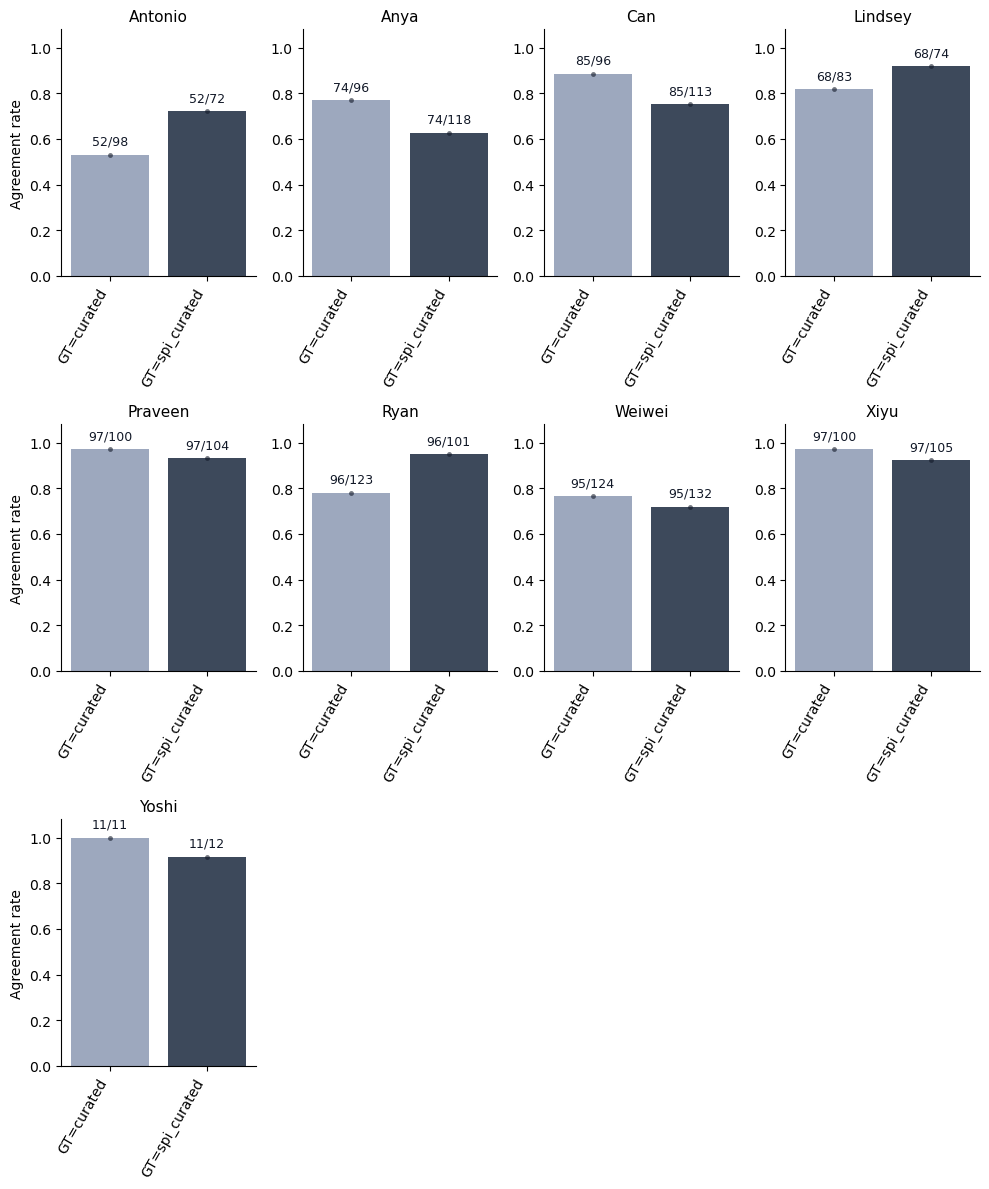

In [24]:
# Analysis 1: seaborn bar plot (person-wise, 4 columns per row)
if len(comparison_results) == 0:
    print("Run Cell 3 first (build comparison_results).")
else:
    rows = []
    for pair_key, res in comparison_results.items():
        person, rat_id, session_id = pair_key.split("/", 2)
        rows.append({
            "pair_key": pair_key,
            "person": person,
            "rat_id": rat_id,
            "session_id": session_id,
            "rate_vs_curated": res["agreement_rate_vs_curated"],
            "rate_vs_spi_curated": res["agreement_rate_vs_spi_curated"],
            "n_agree": res["n_agree"],
            "n_curated": res["n_curated"],
            "n_spi_curated": res["n_spi_curated"],
        })

    agreement_plot_df = pd.DataFrame(rows).sort_values(["person", "rat_id", "session_id"]).reset_index(drop=True)
    display(agreement_plot_df)

    long_df = agreement_plot_df.melt(
        id_vars=["pair_key", "person", "rat_id", "session_id", "n_agree", "n_curated", "n_spi_curated"],
        value_vars=["rate_vs_curated", "rate_vs_spi_curated"],
        var_name="condition",
        value_name="agreement_rate",
    )
    cond_map = {"rate_vs_curated": "GT=curated", "rate_vs_spi_curated": "GT=spi_curated"}
    long_df["condition"] = long_df["condition"].map(cond_map)

    long_df["n_detected"] = np.where(
        long_df["condition"] == "GT=curated",
        long_df["n_curated"],
        long_df["n_spi_curated"],
    )
    long_df["n_matched"] = long_df["n_agree"]

    people = sorted(long_df["person"].unique().tolist())
    n_people = len(people)
    n_cols = 4
    n_rows = int(np.ceil(n_people / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 4 * n_rows), squeeze=False)
    axes_flat = axes.ravel()

    cond_palette = {
        "GT=curated": "#97a6c4",
        "GT=spi_curated": "#384860",
    }
    cond_order = ["GT=curated", "GT=spi_curated"]

    for i, person in enumerate(people):
        ax = axes_flat[i]
        d = long_df[long_df["person"] == person].copy()

        sns.barplot(
            data=d,
            x="condition",
            y="agreement_rate",
            order=cond_order,
            hue="condition",
            hue_order=cond_order,
            palette=cond_palette,
            dodge=False,
            errorbar=None,
            ax=ax,
        )

        sns.stripplot(
            data=d,
            x="condition",
            y="agreement_rate",
            order=cond_order,
            color="#111827",
            alpha=0.6,
            size=3.5,
            jitter=0.10,
            ax=ax,
        )

        bar_heights = d.groupby("condition")["agreement_rate"].mean()
        count_df = d.groupby("condition").agg(
            n_detected=("n_detected", "sum"),
            n_matched=("n_matched", "sum"),
        )

        for j, cond in enumerate(cond_order):
            y = float(bar_heights.get(cond, np.nan)) if cond in bar_heights.index else np.nan
            if not np.isfinite(y):
                y = 0.0

            if cond in count_df.index:
                den = int(count_df.loc[cond, "n_detected"])
                num = int(count_df.loc[cond, "n_matched"])
            else:
                den, num = 0, 0

            y_text = min(1.03, y + 0.03)
            ax.text(
                j,
                y_text,
                f"{num}/{den}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="#111827",
            )

        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        ax.set_title(person, fontsize=11)
        ax.set_xlabel("")
        ax.set_ylim(0, 1.08)
        ax.tick_params(axis="x", labelrotation=60)
        for tick in ax.get_xticklabels():
            tick.set_horizontalalignment("right")
        if i % n_cols == 0:
            ax.set_ylabel("Agreement rate")
        else:
            ax.set_ylabel("")
        sns.despine(ax=ax)

    for k in range(n_people, len(axes_flat)):
        axes_flat[k].axis("off")

    plt.tight_layout()
    plt.show()

,pair_key,person,rat_id,session_id,uid_curated,uid_spi_curated,agreement_score,fr_curated_hz,fr_spi_curated_hz
0,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,1450,59,0.616883,0.402053,0.249370
1,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,1501,518,0.996227,21.169056,21.154862
2,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,1513,516,0.989033,0.516942,0.512823
3,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,1676,15,0.606014,1.125838,0.684598
4,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,1751,124,0.995756,0.391923,0.393259


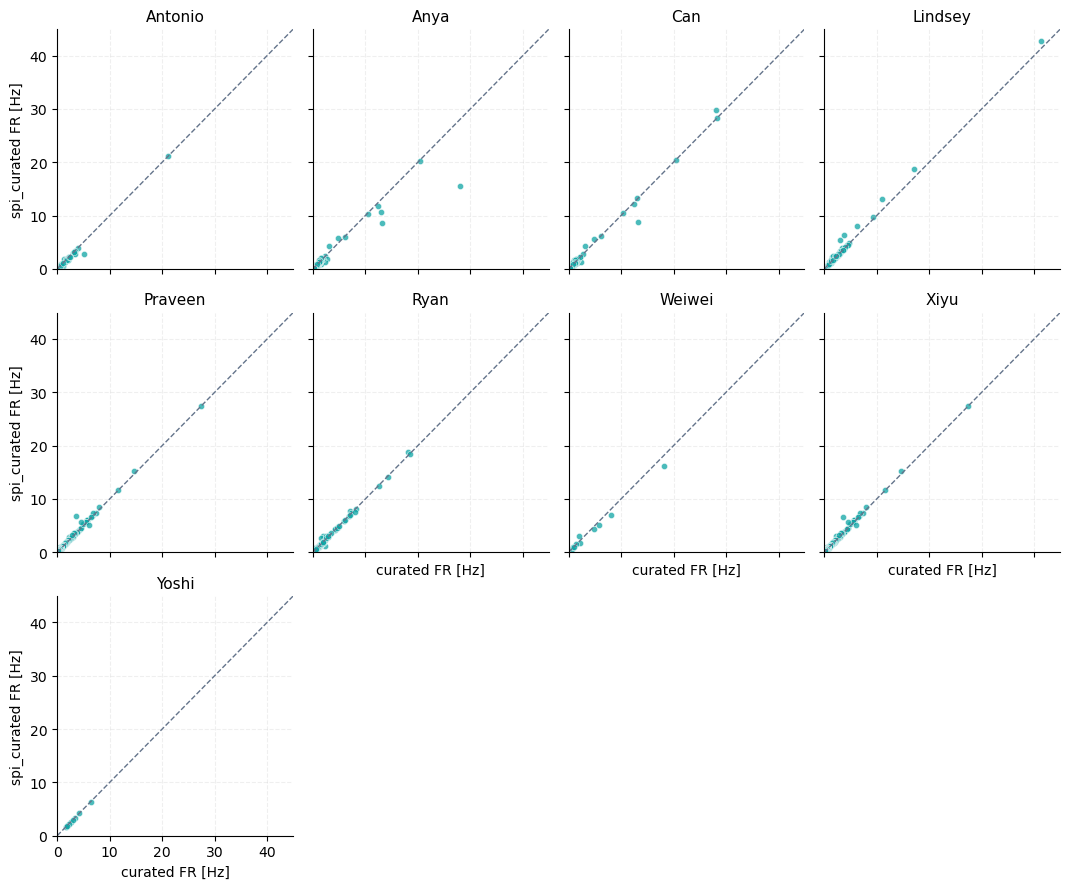

In [25]:
# Analysis 2: compare firing rates of matched units (curated vs spi_curated)
def _estimate_duration_from_spikes(sorting):
    try:
        sf = float(sorting.get_sampling_frequency())
    except Exception:
        return np.nan

    try:
        unit_ids = sorting.get_unit_ids()
    except Exception:
        return np.nan

    max_frame = 0
    has_spike = False
    for uid in unit_ids:
        try:
            st = sorting.get_unit_spike_train(unit_id=uid)
        except Exception:
            continue
        if st is None or len(st) == 0:
            continue
        has_spike = True
        local_max = int(np.max(st))
        if local_max > max_frame:
            max_frame = local_max

    if not has_spike:
        return np.nan

    return (max_frame + 1) / sf

def _get_total_duration_seconds(sorting):
    try:
        duration = float(sorting.get_total_duration())
        if np.isfinite(duration) and duration > 0:
            return duration
    except Exception:
        pass

    try:
        sf = float(sorting.get_sampling_frequency())
        nseg = int(sorting.get_num_segments())
        total_frames = 0
        for i in range(nseg):
            total_frames += int(sorting.get_num_frames(segment_index=i))
        duration = total_frames / sf
        if np.isfinite(duration) and duration > 0:
            return duration
    except Exception:
        pass

    return _estimate_duration_from_spikes(sorting)

def _compute_unit_firing_rates(sorting, unit_ids, fallback_duration=np.nan):
    duration = _get_total_duration_seconds(sorting)
    if (not np.isfinite(duration)) or duration <= 0:
        duration = fallback_duration

    if (not np.isfinite(duration)) or duration <= 0:
        return np.array([np.nan] * len(unit_ids))

    fr = []
    for uid in unit_ids:
        st = sorting.get_unit_spike_train(unit_id=uid)
        fr.append(len(st) / duration)
    return np.asarray(fr, dtype=float)

def _extract_matched_pairs(compare_two_obj, min_score=0.5):
    matched = []
    if not hasattr(compare_two_obj, "agreement_scores"):
        return matched
    scores = compare_two_obj.agreement_scores

    match_series = None
    if hasattr(compare_two_obj, "hungarian_match_12"):
        match_series = compare_two_obj.hungarian_match_12
    elif hasattr(compare_two_obj, "best_match_12"):
        match_series = compare_two_obj.best_match_12

    if match_series is None:
        return matched

    for uid1, uid2 in match_series.items():
        if pd.isna(uid2):
            continue
        if isinstance(uid2, (int, np.integer)) and int(uid2) == -1:
            continue
        try:
            score = float(scores.loc[uid1, uid2])
        except Exception:
            continue
        if score >= min_score:
            matched.append((uid1, uid2, score))
    return matched

if len(sorting_pairs) == 0:
    print("Run Cell 2 first (build sorting_pairs).")
else:
    fr_compare_rows = []
    pair_keys = sorted(sorting_pairs.keys())

    for pair_key in pair_keys:
        sorting_curated = sorting_pairs[pair_key]["curated"]
        sorting_spi = sorting_pairs[pair_key]["spi_curated"]

        cmp2 = scmp.compare_two_sorters(
            sorting1=sorting_curated,
            sorting2=sorting_spi,
            sorting1_name="curated",
            sorting2_name="spi_curated",
            delta_time=delta_time_ms,
            match_score=match_score,
            chance_score=chance_score,
            verbose=False,
        )

        matched_pairs = _extract_matched_pairs(cmp2, min_score=match_score)
        if len(matched_pairs) == 0:
            continue

        ids_curated = [p[0] for p in matched_pairs]
        ids_spi = [p[1] for p in matched_pairs]
        scores = [p[2] for p in matched_pairs]

        dur_cur = _get_total_duration_seconds(sorting_curated)
        dur_spi = _get_total_duration_seconds(sorting_spi)
        common_duration = np.nanmax([dur_cur, dur_spi])

        fr_cur = _compute_unit_firing_rates(sorting_curated, ids_curated, fallback_duration=common_duration)
        fr_spi = _compute_unit_firing_rates(sorting_spi, ids_spi, fallback_duration=common_duration)

        person, rat_id, session_id = pair_key.split("/", 2)
        for uid_c, uid_s, scv, f1, f2 in zip(ids_curated, ids_spi, scores, fr_cur, fr_spi):
            fr_compare_rows.append({
                "pair_key": pair_key,
                "person": person,
                "rat_id": rat_id,
                "session_id": session_id,
                "uid_curated": uid_c,
                "uid_spi_curated": uid_s,
                "agreement_score": scv,
                "fr_curated_hz": f1,
                "fr_spi_curated_hz": f2,
            })

    fr_compare_df = pd.DataFrame(fr_compare_rows)
    display(fr_compare_df.head())

    if len(fr_compare_df) == 0:
        print("No matched units found with current match_score.")
    else:
        people = sorted(fr_compare_df["person"].unique().tolist())
        n_people = len(people)
        n_cols = 4
        n_rows = int(np.ceil(n_people / n_cols))

        # Global axis limit shared across all panels
        all_fr = pd.concat([
            fr_compare_df["fr_curated_hz"].dropna(),
            fr_compare_df["fr_spi_curated_hz"].dropna(),
        ])
        global_vmax = float(np.nanmax(all_fr)) * 1.05 if len(all_fr) > 0 else 1.0
        global_vmax = max(1.0, global_vmax)

        fig, axes = plt.subplots(
            n_rows, n_cols,
            figsize=(2.7 * n_cols, 3.0 * n_rows),
            squeeze=False,
            sharex=True,
            sharey=True,
        )
        axes_flat = axes.ravel()

        for i, person in enumerate(people):
            ax = axes_flat[i]
            d = fr_compare_df[fr_compare_df["person"] == person]
            d_valid = d[np.isfinite(d["fr_curated_hz"]) & np.isfinite(d["fr_spi_curated_hz"])]

            ax.scatter(
                d_valid["fr_curated_hz"],
                d_valid["fr_spi_curated_hz"],
                alpha=0.75,
                s=20,
                color="#0EA5A5",
                edgecolors="white",
                linewidths=0.45,
            )

            ax.plot([0, global_vmax], [0, global_vmax], "--", color="#64748B", linewidth=1)
            ax.set_xlim(0, global_vmax)
            ax.set_ylim(0, global_vmax)
            ax.set_title(person, fontsize=11)
            if i // n_cols == n_rows - 1 or i >= n_people - n_cols:
                ax.set_xlabel("curated FR [Hz]")
            if i % n_cols == 0:
                ax.set_ylabel("spi_curated FR [Hz]")
            ax.grid(alpha=0.2, linestyle="--")
            sns.despine(ax=ax)

        for k in range(n_people, len(axes_flat)):
            axes_flat[k].axis("off")

        plt.tight_layout()
        plt.show()


,pair_key,person,rat_id,session_id,label,phy_log,curation_time_sec,curation_time_min,method
0,Yoshi/Sake/sake_day01,Yoshi,Sake,sake_day01,curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,741.463,12.357717,fallback
1,Yoshi/Sake/sake_day01,Yoshi,Sake,sake_day01,spi_curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,678.684,11.311400,fallback
2,Weiwei/HP04/day_32_20240430,Weiwei,HP04,day_32_20240430,curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,12119.350,201.989167,fallback
3,Weiwei/HP04/day_32_20240430,Weiwei,HP04,day_32_20240430,spi_curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,3461.166,57.686100,fallback
4,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,10203.891,170.064850,fallback
5,Antonio/HP15/hp15_day3_20241129,Antonio,HP15,hp15_day3_20241129,spi_curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,2053.568,34.226133,fallback
6,Ryan/HP04/day_32_20240430,Ryan,HP04,day_32_20240430,curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,12119.350,201.989167,fallback
7,Ryan/HP04/day_32_20240430,Ryan,HP04,day_32_20240430,spi_curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,8642.401,144.040017,fallback
8,Lindsey/NN2/day13,Lindsey,NN2,day13,curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,5407.229,90.120483,fallback
9,Lindsey/NN2/day13,Lindsey,NN2,day13,spi_curated,/local/workdir/ys2375/data/ayadataB1/Sorting_c...,8911.529,148.525483,fallback


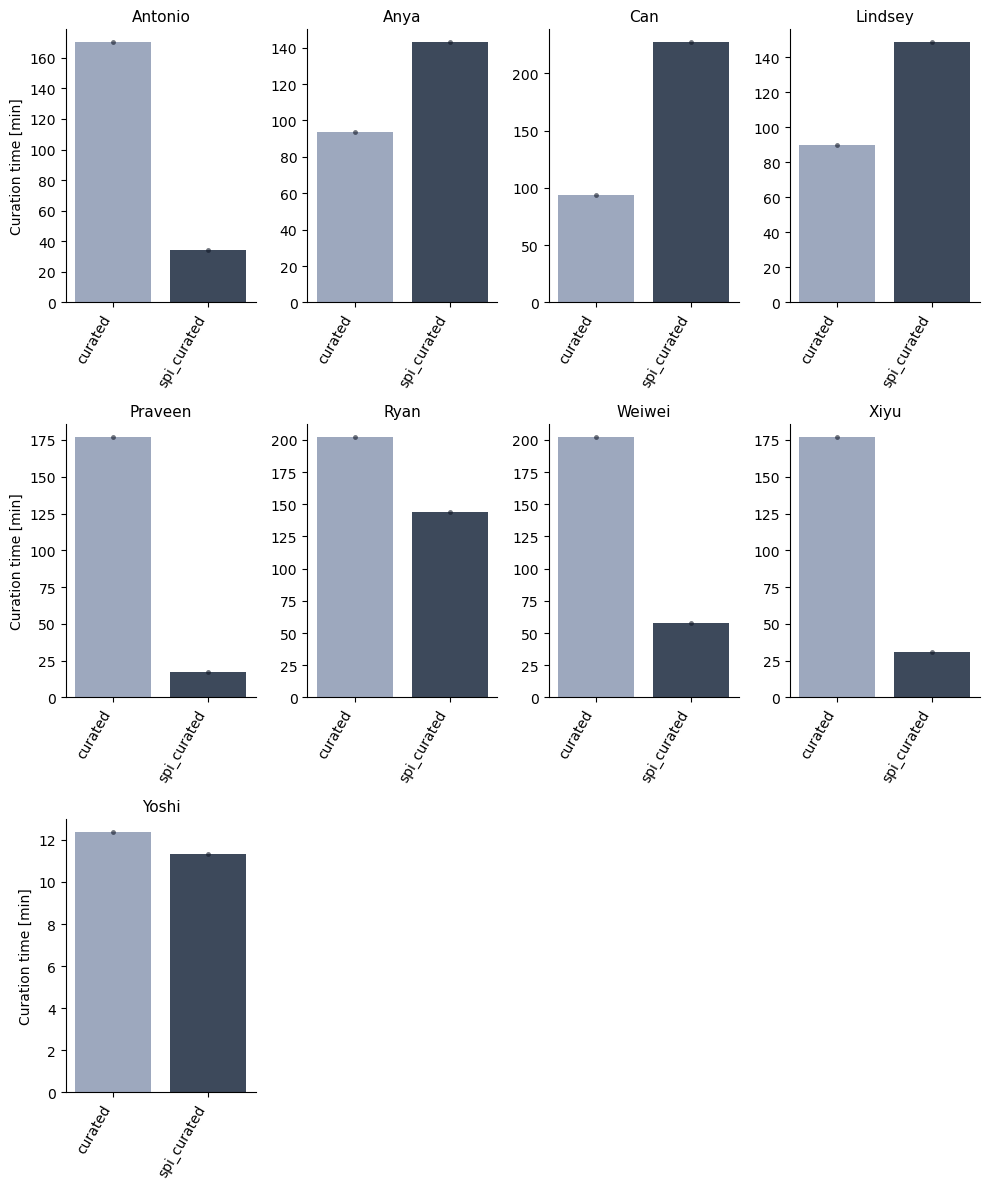

In [26]:
# Analysis 3: phy curation time from phy.log (curated vs spi_curated)
import warnings
import datetime as dt

def _find_phy_log(folder):
    candidates = [
        os.path.join(folder, "phy.log"),
        os.path.join(folder, "sorter_output", "phy.log"),
    ]
    for c in candidates:
        if os.path.exists(c):
            return c
    rec = glob.glob(os.path.join(folder, "**", "phy.log"), recursive=True)
    return rec[0] if len(rec) > 0 else None

def _fallback_parse_phy_log_seconds(filename, merge_gap=30):
    if filename is None or (not os.path.exists(filename)):
        return np.nan
    with open(filename, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()

    patterns = [
        r"(\d{4}-\d{2}-\d{2}[ T]\d{2}:\d{2}:\d{2}(?:[\.,]\d+)?)",
        r"(\d{2}:\d{2}:\d{2}(?:[\.,]\d+)?)",
    ]

    times = []
    for ln in lines:
        ts = None
        for p in patterns:
            m = re.search(p, ln)
            if m is not None:
                ts = m.group(1).replace(",", ".")
                break
        if ts is None:
            continue

        parsed = None
        for fmt in ["%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S.%f", "%Y-%m-%dT%H:%M:%S"]:
            try:
                parsed = dt.datetime.strptime(ts, fmt)
                break
            except Exception:
                pass
        if parsed is None:
            for fmt in ["%H:%M:%S.%f", "%H:%M:%S"]:
                try:
                    t = dt.datetime.strptime(ts, fmt).time()
                    parsed = dt.datetime.combine(dt.date.today(), t)
                    break
                except Exception:
                    pass
        if parsed is not None:
            times.append(parsed)

    if len(times) == 0:
        return np.nan

    times = sorted(times)
    total = 0.0
    seg_start = times[0]
    seg_end = times[0]
    for t in times[1:]:
        if (t - seg_end).total_seconds() <= merge_gap:
            seg_end = t
        else:
            total += (seg_end - seg_start).total_seconds()
            seg_start = t
            seg_end = t
    total += (seg_end - seg_start).total_seconds()
    return total

def _epocharray_total_seconds(epoch_obj):
    if hasattr(epoch_obj, "durations"):
        try:
            d = np.asarray(epoch_obj.durations, dtype=float)
            return float(np.nansum(d))
        except Exception:
            pass
    if hasattr(epoch_obj, "data"):
        try:
            x = np.asarray(epoch_obj.data, dtype=float)
            if x.ndim == 2 and x.shape[1] == 2:
                return float(np.nansum(x[:, 1] - x[:, 0]))
        except Exception:
            pass
    if hasattr(epoch_obj, "length"):
        try:
            return float(epoch_obj.length)
        except Exception:
            pass
    return np.nan

try:
    import neuro_py as npy
    has_neuro_py = True
except Exception:
    has_neuro_py = False
    warnings.warn("neuro_py is not available. Falling back to local phy.log parser.")

merge_gap_sec = 30
time_rows = []
for pair_key, paths in curated_pairs.items():
    person, rat_id, session_id = pair_key.split("/", 2)
    for label in ["curated", "spi_curated"]:
        folder = paths[label]
        log_file = _find_phy_log(folder)

        sec = np.nan
        method = "fallback"
        if has_neuro_py and log_file is not None:
            try:
                ep = npy.raw.spike_sorting.phy_log_to_epocharray(log_file, merge_gap=merge_gap_sec)
                sec = _epocharray_total_seconds(ep)
                method = "neuro_py" if np.isfinite(sec) else "fallback"
            except Exception:
                sec = np.nan

        if (not np.isfinite(sec)) and log_file is not None:
            sec = _fallback_parse_phy_log_seconds(log_file, merge_gap=merge_gap_sec)
            method = "fallback"

        time_rows.append({
            "pair_key": pair_key,
            "person": person,
            "rat_id": rat_id,
            "session_id": session_id,
            "label": label,
            "phy_log": log_file,
            "curation_time_sec": sec,
            "curation_time_min": sec / 60.0 if np.isfinite(sec) else np.nan,
            "method": method,
        })

curation_time_df = pd.DataFrame(time_rows)
display(curation_time_df)

if len(curation_time_df) > 0:
    label_palette = {
        "curated": "#97a6c4",
        "spi_curated": "#384860",
    }
    label_order = ["curated", "spi_curated"]

    people = sorted(curation_time_df["person"].unique().tolist())
    n_people = len(people)
    n_cols = 4
    n_rows = int(np.ceil(n_people / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 4 * n_rows), squeeze=False)
    axes_flat = axes.ravel()

    for i, person in enumerate(people):
        ax = axes_flat[i]
        d = curation_time_df[curation_time_df["person"] == person].copy()

        sns.barplot(
            data=d,
            x="label",
            y="curation_time_min",
            order=label_order,
            hue="label",
            hue_order=label_order,
            palette=label_palette,
            dodge=False,
            errorbar=None,
            ax=ax,
        )

        sns.stripplot(
            data=d,
            x="label",
            y="curation_time_min",
            order=label_order,
            color="#111827",
            alpha=0.6,
            size=3.5,
            jitter=0.10,
            ax=ax,
        )

        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        ax.set_title(person, fontsize=11)
        ax.set_xlabel("")
        ax.tick_params(axis="x", labelrotation=60)
        for tick in ax.get_xticklabels():
            tick.set_horizontalalignment("right")
        if i % n_cols == 0:
            ax.set_ylabel("Curation time [min]")
        else:
            ax.set_ylabel("")
        sns.despine(ax=ax)

    for k in range(n_people, len(axes_flat)):
        axes_flat[k].axis("off")

    plt.tight_layout()
    plt.show()
